In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

plt.rcParams['figure.figsize'] = [16, 14]

In [2]:
def get_files():
    start_file = 9
    stop_file = 20

    image_files = []
    for i in range(stop_file - start_file):
        num = i + start_file
        image_files.append(f'/mnt/hgfs/ztemp/cal/ar0823at_{num:04}.bmp')

    print(image_files)
    return image_files

In [3]:
def get_corners(image_file, CHECKERBOARD):
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK)

    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        return objp, corners2
    else:
        print('No points found')
        return None, None

In [5]:
# Chessboard dimensions
CHECKERBOARD = (7, 10)

res = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(get_corners)(image_file, CHECKERBOARD) for image_file in get_files())

['/mnt/hgfs/ztemp/cal/ar0823at_0009.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0010.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0011.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0012.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0013.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0014.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0015.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0016.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0017.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0018.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0019.bmp']


In [11]:
objpoints = []
imgpoints = []
for i in range(len(res)):
    objpoints.append(res[i][0])
    imgpoints.append(res[i][1])

In [5]:
# Chessboard dimensions
CHECKERBOARD = (7, 10)

# Arrays to store object points and image points
objpoints = []
imgpoints = []

# Prepare object points (0,0,0), (1,0,0), (2,0,0), ..., (6,5,0)
objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Capture images and find chessboard corners
image_files = get_files()
for image_file in image_files:
    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK)

    if ret:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
    else:
        print('No points found')

['/mnt/hgfs/ztemp/cal/ar0823at_0009.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0010.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0011.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0012.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0013.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0014.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0015.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0016.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0017.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0018.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0019.bmp']


['/mnt/hgfs/ztemp/cal/ar0823at_0009.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0010.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0011.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0012.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0013.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0014.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0015.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0016.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0017.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0018.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0019.bmp']


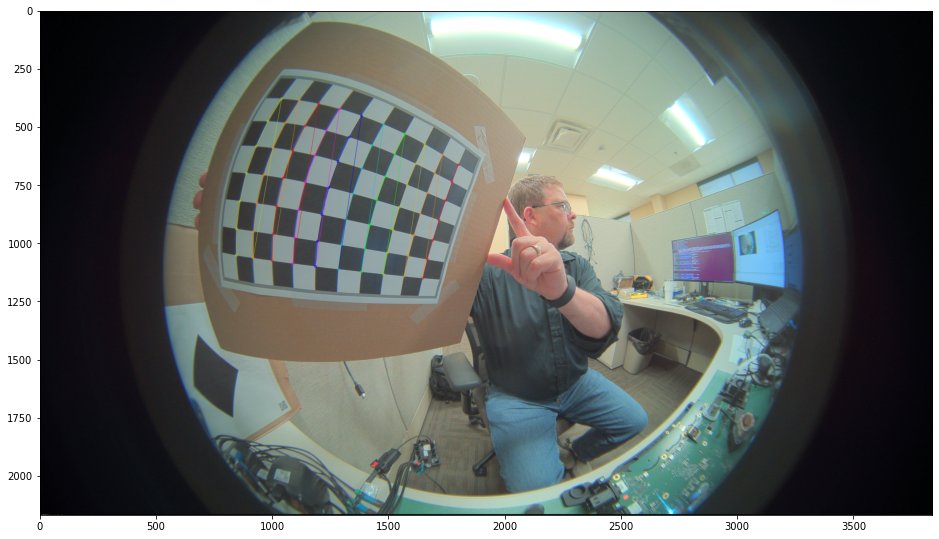

In [20]:
image = cv2.imread(get_files()[-1])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img = cv2.drawChessboardCorners(image, CHECKERBOARD, imgpoints[-1], True)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [21]:
# Calibrate the camera
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]

# Convert object points and image points to the required shape
objectPoints = [np.expand_dims(op, axis=1) for op in objpoints]
imagePoints = [np.expand_dims(ip, axis=1) for ip in imgpoints]

rms, _, _, _, _ = cv2.fisheye.calibrate(
    objectPoints, imgpoints, gray.shape[::-1], K, D, rvecs, tvecs,
    cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)


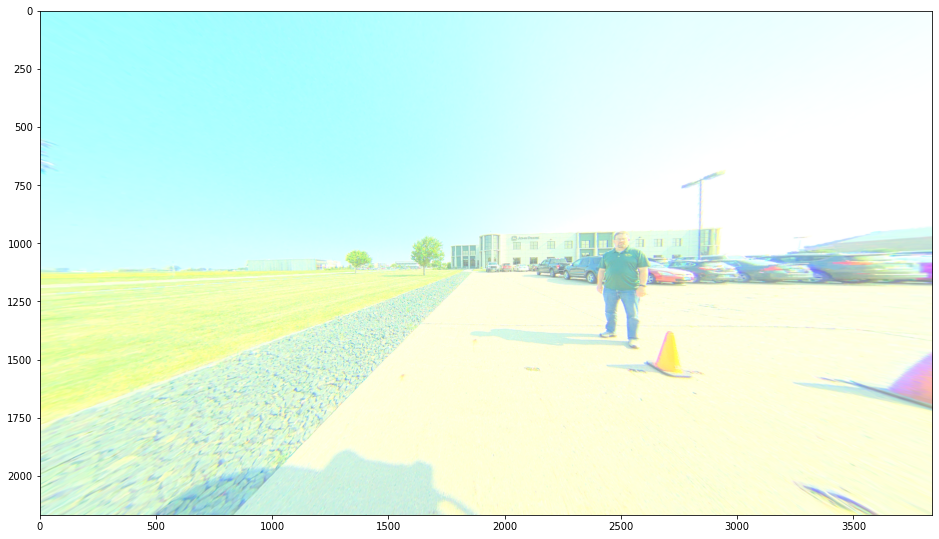

In [66]:
image = cv2.imread('/mnt/hgfs/ztemp/capture8mp/ar0832at0001.bmp')
h, w, _ = image.shape
alpha = 1
growth = 0
new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), alpha, (w + growth, h + growth))
undistort2 = cv2.fisheye.undistortImage(image, K, D, Knew=new_K)
plt.imshow(cv2.cvtColor(undistort2, cv2.COLOR_BGR2RGB))

In [63]:
print(K)
print(new_K)

[[ 7.22921900e+02 -2.25469580e+00  1.86412585e+03]
 [ 0.00000000e+00  7.25679049e+02  1.12015980e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 7.03965515e+02 -2.25469580e+00  1.81524492e+03]
 [ 0.00000000e+00  7.20874390e+02  1.12609734e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
